In [1]:
import pandas as pd
import json

In [4]:
# Connect to the database 
from pymongo import MongoClient

# Requires the PyMongo package.
# https://api.mongodb.com/python/current


# connect to the mongoclient
client = MongoClient('mongodb://localhost:27017/')


# get the database
database = client['youtube']


# get collection videos
videos = database.get_collection("videos")

In [ ]:
# create weekly demand collection
database.create_collection("videos")

#### Import data into database youtube for GB and US

In [5]:
# get collection videos
videos = database.get_collection("videos")

# open the weekly_demand json file
with open("GBvideos.json") as f:
    file_data = json.load(f)
# insert the data into the collection
videos.insert_many(file_data)


# open the weekly_demand json file
with open("USvideos.json") as f:
    file_data = json.load(f)
# insert the data into the collection
videos.insert_many(file_data)

#### Break tags into an Array 

In [7]:
# Break tags into an Array  

tags_format = [
   {
      "$addFields":{
         "tags":{
            "$replaceAll":{
               "input":"$tags",
               "find":"\"",
               "replacement":""
            }
         }
      }
   },
   {
      "$addFields":{
         "tags":{
            "$split":[
               "$tags",
               "|"
            ]
         }
      }
   }
]

videos.update_many({}, tags_format)

In [12]:
# Change data types 
'''
client['youtubedb']['videos'].types.aggregate(
  [
    {
      "$project":
        { 
          "_id": 0,
          "views": { "$toInt": "$double" },
          "likes": { "$toInt": "$double" },
          "dislikes": { "$toInt": "$double" }
        }
    }
  ]
)

'''

### Question 1

In [22]:
# query 
filter={
    'country': 'GB', 
    'channel_title': 'Saturday Night Live'
}
project={
    'title': 1, 
    'views': 1, 
    'likes': 1, 
    'dislikes': 1
}
sort=list({
    'views': -1
}.items())


q1 = videos.find(
  filter=filter,
  projection=project,
  sort=sort
)


In [23]:
# convert to dataframe 
q1_data = pd.DataFrame(q1)

In [24]:
q1_data.head(3)

,_id,title,views,likes,dislikes
0,62ae135f763701a6ac20ad70,Royal Wedding - SNL,8607264,66559,14179
1,62ae135f763701a6ac20acc8,Royal Wedding - SNL,8589119,66465,14171
2,62ae135f763701a6ac20ac18,Royal Wedding - SNL,8570085,66379,14165


In [ ]:
# Or with aggregate 

In [25]:
q1 = videos.aggregate([
{"$match" : { "country" : "GB", 'channel_title': 'Saturday Night Live'} },
{"$project" : {"title": 1 ,"views":1,'likes': 1,'dislikes': 1}},
{"$sort": {"views": -1}}])

# convert to dataframe 
p1_data = pd.DataFrame(q1)


p1_data.head(20)

,_id,title,views,likes,dislikes
0,62ae135f763701a6ac20ad70,Royal Wedding - SNL,8607264,66559,14179
1,62ae135f763701a6ac20acc8,Royal Wedding - SNL,8589119,66465,14171
2,62ae135f763701a6ac20ac18,Royal Wedding - SNL,8570085,66379,14165
3,62ae135f763701a6ac20ab6c,Royal Wedding - SNL,8548321,66287,14154
4,62ae135f763701a6ac20aac4,Royal Wedding - SNL,8534145,66248,14148
5,62ae135f763701a6ac20aa12,Royal Wedding - SNL,8503729,66130,14116
6,62ae135f763701a6ac20a95f,Royal Wedding - SNL,8482595,66039,14099
7,62ae135f763701a6ac20a8ae,Royal Wedding - SNL,8457468,65930,14088
8,62ae135f763701a6ac20a7fe,Royal Wedding - SNL,8431913,65829,14075
9,62ae135f763701a6ac20a751,Royal Wedding - SNL,8390391,65649,14046


#### Remarks on results 

It seems that likes and dislikes follows the views 




### Question 2

In [28]:
videos.count_documents({})

79865

In [13]:
'''
q2 = client['youtubedb']['videos'].aggregate([
{"$match" : { "country" : "GB"} },
{"$count" : "tags"}
{"$project" : {"video_id": 1,"title": 1 ,"views": 1,'likes': 1,'dislikes': 1}},
{"$group" : {"_id":"$channel_title", "num_tags":{ "$sum":1}}},
{"$sort": {"views": -1}}])
''' 

In [35]:
q2 =videos.aggregate([
   {
      "$project": {
         "video_id": 1,
         "views" :1,
         "num_tags": { "$cond": { "if": { "$isArray": "$tags" }, "then": { "$size": "$tags" }, "else": "NA"} }
      }
   },
    
   {
       "$sort": {"views":-1}  
   } 
] )

In [36]:
# convert to dataframe 
q2_data = pd.DataFrame(q2)

In [37]:
q2_data.head(20)

,_id,video_id,views,num_tags
0,62ae135f763701a6ac208493,_I_D_8Z4sJE,424538912,33
1,62ae135f763701a6ac2083cb,_I_D_8Z4sJE,413586699,33
2,62ae135f763701a6ac2082ff,_I_D_8Z4sJE,402650804,33
3,62ae135f763701a6ac20823a,_I_D_8Z4sJE,392036878,33
4,62ae135f763701a6ac208176,_I_D_8Z4sJE,382401497,33
5,62ae135f763701a6ac2080b7,_I_D_8Z4sJE,372399338,33
6,62ae135f763701a6ac208000,_I_D_8Z4sJE,362111555,33
7,62ae135f763701a6ac207f43,_I_D_8Z4sJE,349987176,33
8,62ae135f763701a6ac207e84,_I_D_8Z4sJE,339629489,33
9,62ae135f763701a6ac209c33,9jI-z9QN6g8,337621571,9


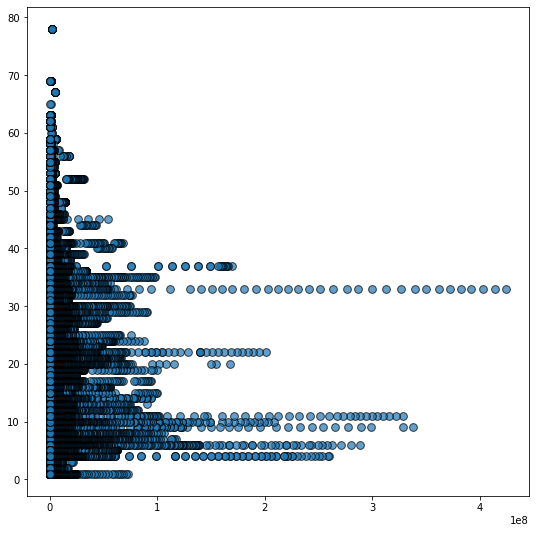

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize layout
fig, ax = plt.subplots(figsize = (9, 9))

# Set the data 
x = q2_data['views']

y = q2_data["num_tags"]

# Add scatterplot
ax.scatter(x, y, s=60, alpha=0.7, edgecolors="k")


In [ ]:
# Remarks on scatter plot results 






In [42]:
# Outliers for views  

Q1,Q3 = np.percentile(q2_data['views'] , [25,75])

IQR = Q3 - Q1
upperlimit = Q3+1.5*IQR
lowerlimit = Q1-1.5*IQR

outliers = q2_data[(q2_data['views'] > upperlimit) | (q2_data['views'] < lowerlimit)]
outliers


,_id,video_id,views,num_tags
0,62ae135f763701a6ac208493,_I_D_8Z4sJE,424538912,33
1,62ae135f763701a6ac2083cb,_I_D_8Z4sJE,413586699,33
2,62ae135f763701a6ac2082ff,_I_D_8Z4sJE,402650804,33
3,62ae135f763701a6ac20823a,_I_D_8Z4sJE,392036878,33
4,62ae135f763701a6ac208176,_I_D_8Z4sJE,382401497,33
...,...,...,...,...
10242,62ae1361763701a6ac21151a,ZCPwpcurYns,5973627,9
10243,62ae135f763701a6ac2034c0,inZzcTXYowY,5973522,4
10244,62ae135f763701a6ac206f8c,mctn16hLzhg,5973411,42
10245,62ae135f763701a6ac207189,9S1Gc1nSXd4,5973102,35


In [44]:
# Outliers for num_tags  

Q1,Q3 = np.percentile(q2_data['num_tags'] , [25,75])

IQR = Q3 - Q1
upperlimit = Q3+1.5*IQR
lowerlimit = Q1-1.5*IQR

outliers = q2_data[(q2_data['num_tags'] > upperlimit) | (q2_data['num_tags'] < lowerlimit)]
outliers

,_id,video_id,views,num_tags
7605,62ae135f763701a6ac209e5d,PfLCyR6Efvw,8581199,57
8252,62ae135f763701a6ac209dc3,PfLCyR6Efvw,7894623,57
10034,62ae135f763701a6ac205bba,ceyU5UBumLU,6132079,59
10040,62ae135f763701a6ac205af4,ceyU5UBumLU,6128584,59
10050,62ae135f763701a6ac205a30,ceyU5UBumLU,6121422,59
...,...,...,...,...
78003,62ae1361763701a6ac20bd12,piyds9slayg,19484,62
78075,62ae1361763701a6ac20bc3c,piyds9slayg,18769,62
78272,62ae1361763701a6ac20bb48,piyds9slayg,16766,62
78392,62ae135f763701a6ac204df6,_gRC4L6lNoc,15350,57


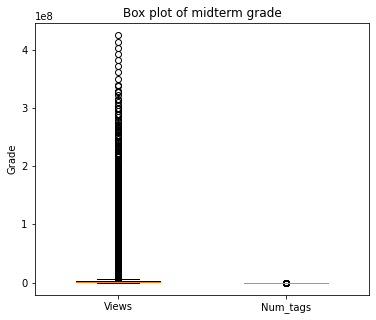

In [46]:
# Boxplot 
fig = plt.figure(figsize=(6,5))



plt.boxplot([q2_data['views'], q2_data['num_tags']], widths=0.5)
plt.xticks([1,2],['Views', 'Num_tags'])
plt.ylabel('Grade')
plt.title('Box plot of midterm grade')
plt.show()

### Question 3

In [ ]:
# For GB 

In [34]:
q3 = videos.aggregate([
    
    {"$match" : 
                   { "country" : "GB", 'comments_disabled': 'False'}
        
    },
    
    {
        "$group" : 
            { 
              "tags" :   ,
              "average_num_views": { "$avg" : "$views"},
              "average_num_likes": { "$avg" : "$likes"},
              "average_num_dislikes":{"$avg" :"$dislikes"}
            } 
    }

])


# Check unwing function


db.collection.aggregate([
  { $unwind: { path: "$Transaction" } },
  {
    $group: {
      _id: "$Transaction.StatusCode",
      Payments: { $max: "$Transaction.Amount" }
    }
  },
  {
    $group: {
      _id: null,
      Paid: { $push: "$Payments" }
    }
  }
])
















# convert to dataframe 
q3_data = pd.DataFrame(q3)


q3_data.head(20)

SyntaxError: invalid syntax (<ipython-input-34-301a3c5b559b>, line 11)

### Question 4

In [9]:
#For enabled comments 

In [13]:
q4 = videos.aggregate([
    
    {"$match" : 
                   { "country" : "GB", 'comments_disabled': 'False'}
        
    },
    
    {
        "$group" : 
            { 
              "_id" : "Enabled" ,
              "average_num_views": { "$avg" : "$views"},
              "average_num_likes": { "$avg" : "$likes"},
              "average_num_dislikes":{"$avg" :"$dislikes"}
            } 
    }

])



# convert to dataframe 
q4_data = pd.DataFrame(q4)


q4_data.head(20)

,_id,average_num_views,average_num_likes,average_num_dislikes
0,Enabled,5.927497e+06,136470.094552,7673.412732


In [24]:
q4_data.iloc[0][1:].values

array([5927496.912824, 136470.09455182694, 7673.412732456255],
      dtype=object)

In [ ]:
# Plot in barplot 

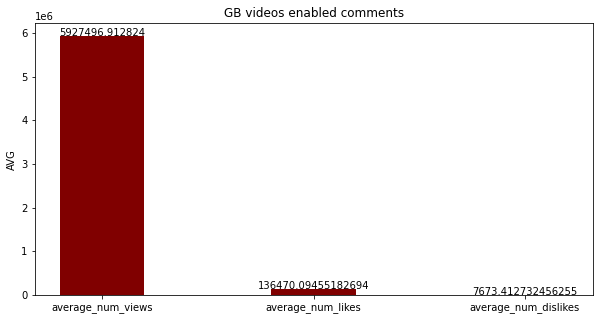

In [30]:

import matplotlib.pyplot as plt


def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
 
  
fig = plt.figure(figsize = (10, 5))

labels = q4_data.columns[1:]
values = q4_data.iloc[0][1:].values
 
# creating the bar plot
plt.bar(labels, values, color ='maroon',
        width = 0.4)

# add number labels 
addlabels(labels, values)

 
#plt.xlabel("")
plt.ylabel("AVG")
plt.title("GB videos enabled comments")
plt.show()

In [ ]:
# For disabled comments 

In [31]:
q4 = videos.aggregate([
    
    {"$match" : 
                   { "country" : "GB", 'comments_disabled': 'True'}
        
    },
    
    {
        "$group" : 
            { 
              "_id" : "Disabled" ,
              "average_num_views": { "$avg" : "$views"},
              "average_num_likes": { "$avg" : "$likes"},
              "average_num_dislikes":{"$avg" :"$dislikes"}
            } 
    }

])



# convert to dataframe 
q4_data = pd.DataFrame(q4)


q4_data.head(20)

,_id,average_num_views,average_num_likes,average_num_dislikes
0,Disabled,5.041301e+06,25332.09224,4206.14202


In [32]:
# Plot in barplot 

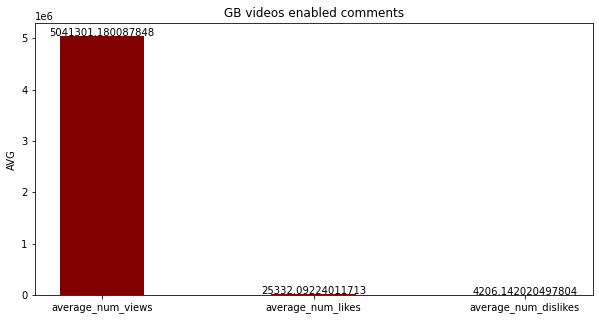

In [33]:

import matplotlib.pyplot as plt


def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
 
  
fig = plt.figure(figsize = (10, 5))

labels = q4_data.columns[1:]
values = q4_data.iloc[0][1:].values
 
# creating the bar plot
plt.bar(labels, values, color ='maroon',
        width = 0.4)

# add number labels 
addlabels(labels, values)

 
#plt.xlabel("")
plt.ylabel("AVG")
plt.title("GB videos enabled comments")
plt.show()